In [2]:
%load_ext autoreload
%autoreload 2
from ga.numba_ga import GaHMM
from data.data import Observations
import pandas
import ga.crossover as crossover
import ga.mutation as mutation
import numpy
import seaborn as sns
import hmm.bw as bw
import ga.representation as representation
from ga.numba_ga import normalize_population, calculate_fitness_of_population, train_population_with_bw

In [3]:
mutation_df = pandas.read_csv('evaluation/mutation_df.csv')
crossover_df = pandas.read_csv('evaluation/crossover_df.csv')

In [21]:
# crossover_df.groupby(['n_bw_iterations', 'crossover_func'])['parent1_fitness', 'parent2_fitness']
# crossover_df['parents_max'] = crossover_df[['parent1_fitness', 'parent2_fitness']].max(axis=1)
# crossover_df[crossover_df['crossover_func'] == '1X']

,Unnamed: 0,dataset,n_seqs,n_symbols,n_states,n_bw_iterations,crossover_func,parent1_fitness,parent2_fitness,child_fitness,parents_max
0,0,fsdd,10,128,5,0,1X,-2794.816316,-2696.964505,-2677.282638,-2696.964505
1,1,fsdd,10,128,5,0,1X,-2744.383492,-2876.580886,-2870.574750,-2744.383492
2,2,fsdd,10,128,5,0,1X,-2996.673561,-2873.807386,-2915.896882,-2873.807386
3,3,fsdd,10,128,5,0,1X,-3004.350557,-2995.510869,-3009.897606,-2995.510869
4,4,fsdd,10,128,5,0,1X,-2809.398291,-2796.122859,-2776.905932,-2796.122859
...,...,...,...,...,...,...,...,...,...,...,...
40495,40495,fsdd,10,128,5,20,1X,-1235.294178,-1083.416429,-1235.294178,-1083.416429
40496,40496,fsdd,10,128,5,20,1X,-1076.300941,-1234.497748,-1160.924880,-1076.300941
40497,40497,fsdd,10,128,5,20,1X,-1117.196537,-1201.605450,-1157.494493,-1117.196537
40498,40498,fsdd,10,128,5,20,1X,-1225.867331,-1279.851797,-inf,-1225.867331


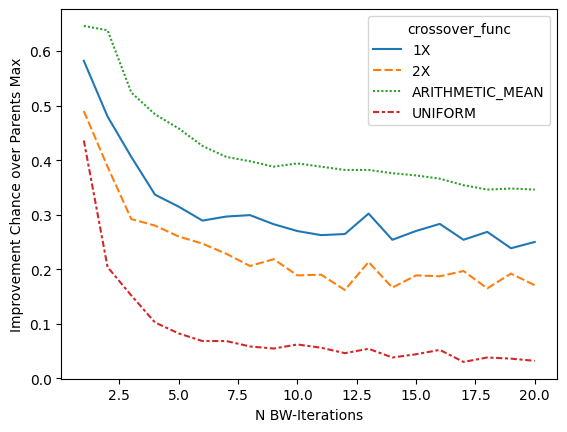

In [14]:
def how_often_is_crossover_better(crossover_df: pandas.DataFrame):
    crossover_df = crossover_df[crossover_df['n_bw_iterations'] > 0]
    child_is_fitter_than_both_parents = crossover_df[crossover_df['child_fitness'] > crossover_df['parents_min']]
    how_often_is_child_fitter = child_is_fitter_than_both_parents.groupby(['crossover_func', 'n_bw_iterations'])['child_fitness'].count()
    out_of = crossover_df.groupby(['crossover_func', 'n_bw_iterations'])['child_fitness'].count()

    soos = (how_often_is_child_fitter / out_of).fillna(0)
    
    df = pandas.DataFrame(soos).reset_index()
    graph = sns.lineplot(df, x='n_bw_iterations', y='child_fitness', style='crossover_func', hue='crossover_func')
    graph.set(xlabel="N BW-Iterations", ylabel="Improvement Chance over Parents Min")
    # df = df.pivot('crossover_func', 'n_bw_iterations', 'child_fitness')
    # sns.heatmap(df)
    # return df
crossover_df['parents_max'] = crossover_df[['parent1_fitness', 'parent2_fitness']].max(axis=1)
crossover_df['parents_min'] = crossover_df[['parent1_fitness', 'parent2_fitness']].min(axis=1)
how_often_is_crossover_better(crossover_df)

In [5]:
mutation_df['fitness_increase'] = (mutation_df['fitness_after_mutation'] - mutation_df['fitness_before_mutation'])
# mutation_df

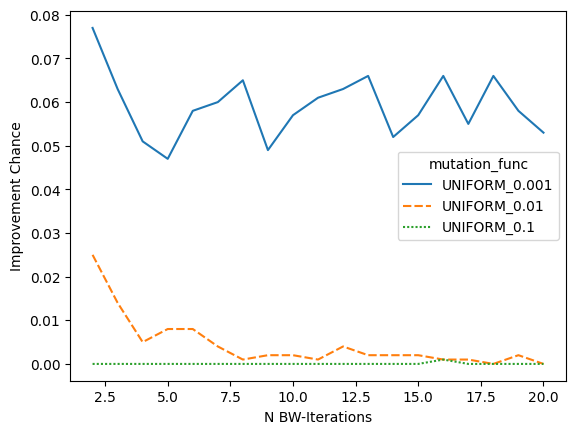

In [6]:
def how_often_is_mutation_better(mutation_df: pandas.DataFrame):
    mutation_df = mutation_df[mutation_df['n_bw_iterations'] > 1]
    did_improve = mutation_df[mutation_df['fitness_increase'] > 0].groupby(['mutation_func', 'n_bw_iterations'])['fitness_increase'].count()
    out_of = mutation_df.groupby(['mutation_func', 'n_bw_iterations'])['fitness_increase'].count()

    soos = (did_improve / out_of).fillna(0)
    
    df = pandas.DataFrame(soos).reset_index()
    graph = sns.lineplot(df, x='n_bw_iterations', y='fitness_increase', style='mutation_func', hue='mutation_func')
    graph.set(xlabel="N BW-Iterations", ylabel="Improvement Chance")

how_often_is_mutation_better(mutation_df)

[Text(0.5, 0, 'N BW-Iterations'), Text(0, 0.5, 'Mean Fitness Change')]

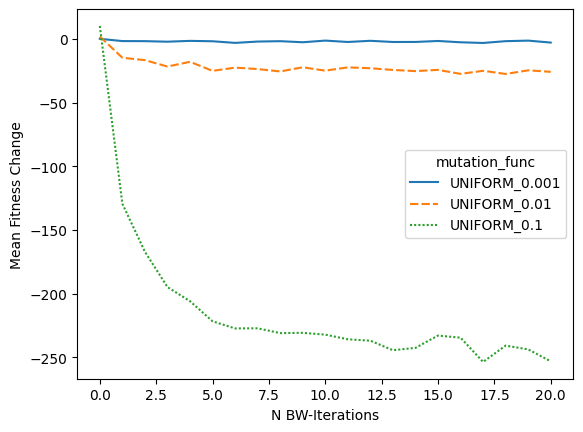

In [7]:
# series = mutation_df.groupby(['n_bw_iterations', 'mutation_func'])['fitness_increase'].mean()
# df = pandas.DataFrame(series).reset_index()
# graph = sns.lineplot(df, x='n_bw_iterations', y='fitness_increase', style='mutation_func', hue='mutation_func')
# graph.set(xlabel="N BW-Iterations", ylabel="Mean Fitness Change")
# mutation_df

In [43]:
series = mutation_df.groupby(['mutation_func', 'n_bw_iterations'])['fitness_after_mutation'].mean()
df = pandas.DataFrame(series).reset_index()
# sns.lineplot(df, x='n_bw_iterations', y='fitness_after_mutation', style='mutation_func')

[Text(0.5, 0, 'N BW-Iterations'), Text(0, 0.5, 'Mean Fitness after mutation')]

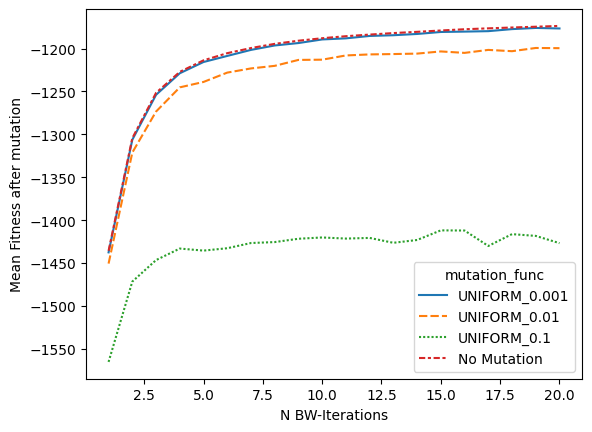

In [57]:
df2 = mutation_df.groupby('n_bw_iterations')['fitness_before_mutation'].mean()

# sns.scatterplot(mutation_df, x='fitness_before_mutation', y='fitness_after_mutation', hue='mutation_func')
# mutation_df[mutation_df['n_bw_iterations'] == 0]
# pandas.concat(df, df2)
df2 = pandas.DataFrame(df2).reset_index()
df2['mutation_func'] = 'No Mutation'
df2 = df2.rename(columns={'fitness_before_mutation': 'fitness_after_mutation'})
df3 = pandas.concat([df, df2])
df3 = df3[df3['n_bw_iterations'] > 0]
graph = sns.lineplot(df3, x='n_bw_iterations', y='fitness_after_mutation', style='mutation_func', hue='mutation_func')
graph.set(xlabel="N BW-Iterations", ylabel="Mean Fitness after mutation")

In [51]:
mutation_df

,Unnamed: 0,dataset,n_seqs,n_symbols,n_states,n_bw_iterations,mutation_func,fitness_before_mutation,fitness_after_mutation,fitness_increase
0,0,fsdd,10,128,5,0,UNIFORM_0.1,-2694.990738,-2693.636019,1.354719
1,1,fsdd,10,128,5,0,UNIFORM_0.1,-2919.249009,-2878.590603,40.658407
2,2,fsdd,10,128,5,0,UNIFORM_0.1,-2833.080424,-2901.499738,-68.419314
3,3,fsdd,10,128,5,0,UNIFORM_0.1,-2936.160229,-2997.749905,-61.589676
4,4,fsdd,10,128,5,0,UNIFORM_0.1,-2846.701916,-2808.068089,38.633827
...,...,...,...,...,...,...,...,...,...,...
62995,62995,fsdd,10,128,5,20,UNIFORM_0.001,-1223.923681,-1223.923681,0.000000
62996,62996,fsdd,10,128,5,20,UNIFORM_0.001,-1108.649830,-1108.988652,-0.338822
62997,62997,fsdd,10,128,5,20,UNIFORM_0.001,-1210.793922,-1210.793922,0.000000
62998,62998,fsdd,10,128,5,20,UNIFORM_0.001,-1117.152509,-1117.447484,-0.294975
